Test 3: Using Elec2 dataset

In [1]:
from river import naive_bayes, stream, drift, metrics, datasets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

In [2]:
print("\rDownloading Dataset...", end = '\r')
dataset = datasets.Elec2()
if not dataset.is_downloaded:
    dataset.download()
file = open(dataset.path, 'r')
content = file.readlines()[1:]
file.close()

In [3]:
k = 48
h = []
_X = []
_Y = []
error = []

In [4]:
for i in range(k):
    h = h + [float(j) for j in content[i].split(',')[3:7]]
for i in range(k, len(content)):
    c = [float(j) for j in content[i].split(',')[3:7]]
    _X.append(h)
    if content[i].split(',')[-1] == "UP\n":
        _Y.append(True)
    else:
        _Y.append(False)
    h = h[4:] + c

X = np.array(_X)
Y = np.array(_Y)

In [5]:
class Model:
    def __init__(self, detector):
        #self._model = naive_bayes.GaussianNB()
        self.model = naive_bayes.GaussianNB() #copy.copy(self._model)
        self._detector = detector
        self.detector = copy.copy(self._detector)
        self.acc = 0
        self.accL = 48
        self.errors = []
        self.drifts = []
        self.retrain_set = []
        self.k = 48 * 7

    def foward(self, x, y, i):
        # Training
        self.model.learn_one(x, y)

        # Retraining Set
        self.retrain_set.append((x, y))
        if len(self.retrain_set) > self.k:
            self.retrain_set.pop(0)

        # Accuracy
        if y == self.model.predict_one(x):
            self.acc += 1
        
        # Every day (48)
        if i % self.accL == 0:
            e = self.acc / self.accL
            self.acc = 0

            self.errors.append(e)

            if self.detector:
                self.detector.update(e)

                # Drift Detected
                if self.detector.drift_detected:
                    self.model = naive_bayes.GaussianNB() #copy.copy(self._model)
                    self.drifts.append(i)

                    # Retrain
                    for _x, _y in self.retrain_set:
                        self.model.learn_one(_x, _y)

            return e
        return 0
    
    def get_eval(self):
        return (self.errors, self.drifts)

In [6]:
NB = Model(None)    
NBAdwin = Model(drift.ADWIN(delta=0.05))
NBAtwin = Model(drift.atwin.ATWIN(delta=0.05, temp=1/10))

In [7]:
i = 0

for x, y in stream.iter_array(X, Y):
    NB.foward(x, y, i)
    i += 1
    if i % 100 == 0:
        print(f"\rTraining Progress: {i}/{len(X)}", end = '\r')
print("Training Completed             ")

Training Completed             


In [8]:
i = 0

for x, y in stream.iter_array(X, Y):
    NBAdwin.foward(x, y, i)
    i += 1
    if i % 100 == 0:
        print(f"\rTraining Progress: {i}/{len(X)}", end = '\r')
print("Training Completed             ")

Training Completed             


In [9]:
i = 0

for x, y in stream.iter_array(X, Y):
    NBAtwin.foward(x, y, i)
    i += 1
    if i % 100 == 0:
        print(f"\rTraining Progress: {i}/{len(X)}", end = '\r')
print("Training Completed             ")

Training Completed             


In [27]:
def plot_data(d1, d2, d3):
    fig = plt.figure(figsize=(7,6), tight_layout=True)
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 3, 3])
    ax1, ax2, ax3 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

    ax1.grid()
    ax1.plot(d1, label='NB')
    ax1.set_ylabel('NB')

    ax2.grid()
    ax2.plot(d2, label='NBAdwin')
    ax2.set_ylabel('NBAdwin')

    ax3.grid()
    ax3.plot(d3, label='NBAtwin')
    ax3.set_ylabel('NBAtwin')

    """
    if dist_a[1] is not None:
        for drift_detected in dist_a[1]:
            ax1.axvline(drift_detected, color='red')
            ax3.axvline(drift_detected, color='red')
    if dist_b[1] is not None:
        for drift_detected in dist_b[1]:
            ax2.axvline(drift_detected, color='red')
            ax3.axvline(drift_detected, color='red')
    """
    
    plt.show()

In [33]:
def cram_plot(nb, da, db):
    plt.plot(nb, color='black')
    plt.plot(da, color="blue")
    plt.plot(db, color='red')

    """
    if da[1] is not None:
        for drift_detected in da[1]:
            plt.axvline(drift_detected, color='red')
    if db[1] is not None:
        for drift_detected in db[1]:
            plt.axvline(drift_detected, color='blue')
    """

    plt.legend(["NB", "NBAdwin", "NBAtwin"], loc ="lower right") 
    plt.xlabel("Examples")
    plt.ylabel("Accuracy")

    plt.show()

In [12]:
Nb = NB.get_eval()
Ad = NBAdwin.get_eval()
At = NBAtwin.get_eval()

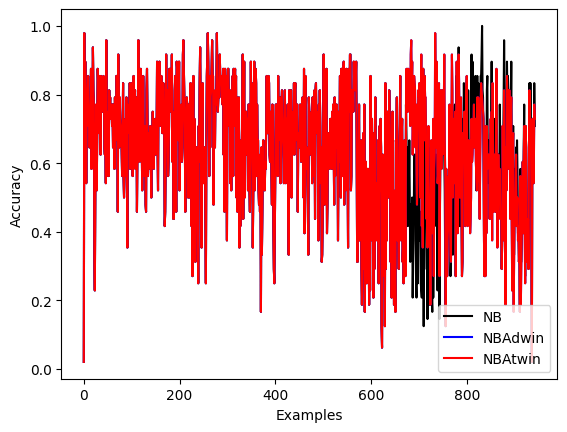

In [17]:
cram_plot(Nb[0], Ad[0], At[0])

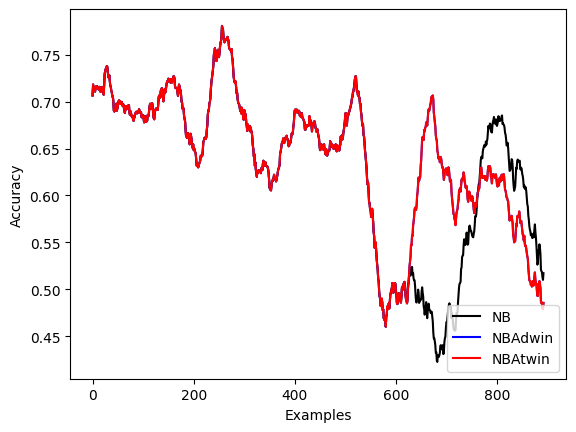

In [34]:
cat = 50

cram_plot(
    [sum(Nb[0][i:i+cat])/cat for i in range(len(Nb[0]) - cat)], 
    [sum(Ad[0][i:i+cat])/cat for i in range(len(Ad[0]) - cat)], 
    [sum(At[0][i:i+cat])/cat for i in range(len(At[0]) - cat)], 
    )

In [14]:
print(f'Control: {sum(Nb[0])/len(Nb[0])}')
print(f'Adwin: {sum(Ad[0])/len(Ad[0])}')
print(f'    Drifts: {len(Ad[1])}')
print(f'Atwin: {sum(At[0])/len(At[0])}')
print(f'    Drifts: {len(At[1])}')

Control: 0.6294185224460948
Adwin: 0.6400892541534113
    Drifts: 1
Atwin: 0.6400892541534113
    Drifts: 1
